In [1]:
import networkx as nx
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import time
import pandas.util.testing as tm

import torch
import scipy.sparse
from torch import Tensor
from torch.utils.dlpack import to_dlpack, from_dlpack

import torch.nn as nn

import torch_geometric.data
from torch_geometric.data import Data
from torch_geometric.utils import from_networkx, to_networkx
from torch_geometric.utils import k_hop_subgraph, from_scipy_sparse_matrix, to_scipy_sparse_matrix
from torch_geometric.utils import is_undirected, to_undirected
from scipy.sparse import csr_matrix

from pgmpy.estimators.CITests import chi_square
from scipy.special import softmax

from sklearn.model_selection import train_test_split

import torch.nn.functional as F
from torch.nn import BatchNorm1d
from torch_geometric.nn import GCNConv

import sys, os
sys.path.append('/cluster/home/kamara/Explain')

import json
import pickle
import time
from datetime import datetime
import argparse
import random
import itertools

from dataset import *
from evaluate import *
from explainer import *
#from gengraph import gen_syn1
from gnn_model import GcnEncoderNode
from gnn_train import train
from gnn_eval import gnn_scores, get_labels, get_proba
from gen_utils import check_dir, get_subgraph, from_edge_index_to_adj, from_adj_to_edge_index
from parser_utils import arg_parse



/tmp/ipykernel_27577/3231340530.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
import matplotlib 
import matplotlib.pyplot as plt


print(matplotlib.pyplot.get_backend())

agg


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F




# GCN basic operation
class GraphConv(nn.Module):
    def __init__(
        self,
        input_dim,
        output_dim,
        add_self=False,
        normalize_embedding=False,
        dropout=0.0,
        bias=True,
        gpu=True,
        att=False,
    ):
        super(GraphConv, self).__init__()
        self.att = att
        self.add_self = add_self
        self.dropout = dropout
        if dropout > 0.001:
            self.dropout_layer = nn.Dropout(p=dropout)
        self.normalize_embedding = normalize_embedding
        self.input_dim = input_dim
        self.output_dim = output_dim
        if not gpu:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim)
                )
            if att:
                self.att_weight = nn.Parameter(torch.FloatTensor(input_dim, input_dim))
        else:
            self.weight = nn.Parameter(torch.FloatTensor(input_dim, output_dim).cuda())
            if add_self:
                self.self_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, output_dim).cuda()
                )
            if att:
                self.att_weight = nn.Parameter(
                    torch.FloatTensor(input_dim, input_dim).cuda()
                )
        if bias:
            if not gpu:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim))
            else:
                self.bias = nn.Parameter(torch.FloatTensor(output_dim).cuda())
        else:
            self.bias = None

        # self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, adj):
        if self.dropout > 0.001:
            x = self.dropout_layer(x)
        # deg = torch.sum(adj, -1, keepdim=True)
        if self.att:
            x_att = torch.matmul(x, self.att_weight)
            # import pdb
            # pdb.set_trace()
            att = x_att @ x_att.permute(0, 2, 1)
            # att = self.softmax(att)
            adj = adj * att
        
        y = torch.matmul(adj, x)
        y = torch.matmul(y, self.weight)
        if self.add_self:
            self_emb = torch.matmul(x, self.self_weight)
            y += self_emb
        if self.bias is not None:
            y = y + self.bias
        #if self.normalize_embedding:
            #y = F.normalize(y, p=2, dim=2)
            # print(y[0][0])
        return y, adj


class GcnEncoderGraph(nn.Module):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers,
        pred_hidden_dims=[],
        concat=True,
        bn=True,
        dropout=0.0,
        add_self=False,
        args=None,
    ):
        super(GcnEncoderGraph, self).__init__()
        self.concat = concat
        add_self = add_self
        self.bn = bn
        self.num_layers = num_layers
        self.num_aggs = 1

        self.bias = True
        self.gpu = args['gpu']
        if args['method'] == "att":
            self.att = True
        else:
            self.att = False
        #if args is not None:
            #self.bias = args.bias

        self.conv_first, self.conv_block, self.conv_last = self.build_conv_layers(
            input_dim,
            hidden_dim,
            embedding_dim,
            num_layers,
            add_self,
            normalize=True,
            dropout=dropout,
        )
        self.act = nn.ReLU()
        self.label_dim = label_dim

        if concat:
            self.pred_input_dim = hidden_dim * (num_layers - 1) + embedding_dim
        else:
            self.pred_input_dim = embedding_dim
        self.pred_model = self.build_pred_layers(
            self.pred_input_dim, pred_hidden_dims, label_dim, num_aggs=self.num_aggs
        )

        for m in self.modules():
            if isinstance(m, GraphConv):
                init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain("relu"))
                if m.att:
                    init.xavier_uniform_(
                        m.att_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.add_self:
                    init.xavier_uniform_(
                        m.self_weight.data, gain=nn.init.calculate_gain("relu")
                    )
                if m.bias is not None:
                    init.constant_(m.bias.data, 0.0)

    def build_conv_layers(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        num_layers,
        add_self,
        normalize=False,
        dropout=0.0,
    ):
        conv_first = GraphConv(
            input_dim=input_dim,
            output_dim=hidden_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        conv_block = nn.ModuleList(
            [
                GraphConv(
                    input_dim=hidden_dim,
                    output_dim=hidden_dim,
                    add_self=add_self,
                    normalize_embedding=normalize,
                    dropout=dropout,
                    bias=self.bias,
                    gpu=self.gpu,
                    att=self.att,
                )
                for i in range(num_layers - 2)
            ]
        )
        conv_last = GraphConv(
            input_dim=hidden_dim,
            output_dim=embedding_dim,
            add_self=add_self,
            normalize_embedding=normalize,
            bias=self.bias,
            gpu=self.gpu,
            att=self.att,
        )
        return conv_first, conv_block, conv_last

    def build_pred_layers(
        self, pred_input_dim, pred_hidden_dims, label_dim, num_aggs=1
    ):
        pred_input_dim = pred_input_dim * num_aggs
        if len(pred_hidden_dims) == 0:
            pred_model = nn.Linear(pred_input_dim, label_dim)
        else:
            pred_layers = []
            for pred_dim in pred_hidden_dims:
                pred_layers.append(nn.Linear(pred_input_dim, pred_dim))
                pred_layers.append(self.act)
                pred_input_dim = pred_dim
            pred_layers.append(nn.Linear(pred_dim, label_dim))
            pred_model = nn.Sequential(*pred_layers)
        return pred_model

    def construct_mask(self, max_nodes, batch_num_nodes):
        """ For each num_nodes in batch_num_nodes, the first num_nodes entries of the 
        corresponding column are 1's, and the rest are 0's (to be masked out).
        Dimension of mask: [batch_size x max_nodes x 1]
        """
        # masks
        packed_masks = [torch.ones(int(num)) for num in batch_num_nodes]
        batch_size = len(batch_num_nodes)
        out_tensor = torch.zeros(batch_size, max_nodes)
        for i, mask in enumerate(packed_masks):
            out_tensor[i, : batch_num_nodes[i]] = mask
        return out_tensor.unsqueeze(2).cuda()

    def apply_bn(self, x):
        """ Batch normalization of 3D tensor x
        """
        bn_module = nn.BatchNorm1d(x.size()[1])
        if self.gpu:
            bn_module = bn_module.cuda()
        return bn_module(x)

    def gcn_forward(
        self, x, adj, conv_first, conv_block, conv_last, embedding_mask=None
    ):

        """ Perform forward prop with graph convolution.
        Returns:
            Embedding matrix with dimension [batch_size x num_nodes x embedding]
            The embedding dim is self.pred_input_dim
        """
        x, adj_att = conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        x_all = [x]
        adj_att_all = [adj_att]
        # out_all = []
        # out, _ = torch.max(x, dim=1)
        # out_all.append(out)
        for i in range(len(conv_block)):
            x, _ = conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            x_all.append(x)
            adj_att_all.append(adj_att)
        x, adj_att = conv_last(x, adj)
        x_all.append(x)
        adj_att_all.append(adj_att)
        # x_tensor: [batch_size x num_nodes x embedding]
        x_tensor = torch.cat(x_all, dim=2)
        if embedding_mask is not None:
            x_tensor = x_tensor * embedding_mask
        self.embedding_tensor = x_tensor

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)
        return x_tensor, adj_att_tensor

    def forward(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            self.embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            self.embedding_mask = None

        # conv
        x, adj_att = self.conv_first(x, adj)
        x = self.act(x)
        if self.bn:
            x = self.apply_bn(x)
        out_all = []
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        adj_att_all = [adj_att]
        for i in range(self.num_layers - 2):
            x, adj_att = self.conv_block[i](x, adj)
            x = self.act(x)
            if self.bn:
                x = self.apply_bn(x)
            out, _ = torch.max(x, dim=1)
            out_all.append(out)
            if self.num_aggs == 2:
                out = torch.sum(x, dim=1)
                out_all.append(out)
            adj_att_all.append(adj_att)
        x, adj_att = self.conv_last(x, adj)
        adj_att_all.append(adj_att)
        # x = self.act(x)
        out, _ = torch.max(x, dim=1)
        out_all.append(out)
        if self.num_aggs == 2:
            out = torch.sum(x, dim=1)
            out_all.append(out)
        if self.concat:
            output = torch.cat(out_all, dim=1)
        else:
            output = out

        # adj_att_tensor: [batch_size x num_nodes x num_nodes x num_gc_layers]
        adj_att_tensor = torch.stack(adj_att_all, dim=3)

        self.embedding_tensor = output
        ypred = self.pred_model(output)
        # print(output.size())
        return ypred, adj_att_tensor

    def loss(self, pred, label, type="softmax"):
        # softmax + CE
        if type == "softmax":
            return F.cross_entropy(pred, label, size_average=True)
        elif type == "margin":
            batch_size = pred.size()[0]
            label_onehot = torch.zeros(batch_size, self.label_dim).long().cuda()
            label_onehot.scatter_(1, label.view(-1, 1), 1)
            return torch.nn.MultiLabelMarginLoss()(pred, label_onehot)

        # return F.binary_cross_entropy(F.sigmoid(pred[:,0]), label.float())


class GcnEncoderNode(GcnEncoderGraph):
    def __init__(
        self,
        input_dim,
        hidden_dim,
        embedding_dim,
        label_dim,
        num_layers,
        pred_hidden_dims=[],
        concat=True,
        bn=True,
        dropout=0.0,
        args=None,
    ):
        super(GcnEncoderNode, self).__init__(
            input_dim,
            hidden_dim,
            embedding_dim,
            label_dim,
            num_layers,
            pred_hidden_dims,
            concat,
            bn,
            dropout,
            args=args,
        )
        #if hasattr(args, "loss_weight"):
            #print("Loss weight: ", args.loss_weight)
            #self.celoss = nn.CrossEntropyLoss(weight=args.loss_weight)
        #else:
        self.celoss = nn.CrossEntropyLoss()
        self.prob_act = nn.Softmax(dim=1)
        
        
        
    def forward_batch(self, x, adj, batch_num_nodes=None, **kwargs):
        # mask
        max_num_nodes = adj.size()[1]
        if batch_num_nodes is not None:
            embedding_mask = self.construct_mask(max_num_nodes, batch_num_nodes)
        else:
            embedding_mask = None

        self.adj_atts = []
        self.embedding_tensor, adj_att = self.gcn_forward(
            x, adj, self.conv_first, self.conv_block, self.conv_last, embedding_mask
        )
        pred = self.pred_model(self.embedding_tensor)
        return pred, adj_att

    def forward(self, x, edge_index, batch_num_nodes=None, **kwargs):
        #Encoder Node receives no batch - only one graph
        max_n = x.size(0)
        adj = from_edge_index_to_adj(edge_index, max_n)
        pred, adj_att = self.forward_batch(x.expand(1,-1,-1), adj.expand(1,-1,-1), batch_num_nodes, **kwargs)
        ypred = torch.squeeze(pred, 0)
        return ypred
    
    def get_proba(self, ypred):
        yprob = self.prob_act(ypred)
        return yprob
    
    def get_labels(self, ypred):
        ylabels = torch.argmax(ypred, dim=1)
        return ylabels

    def loss(self, pred, label):
        # Transpose if batch dim:
        #pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)
    


In [4]:
from torch.nn import BatchNorm1d

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_classes, num_layers, hidden_dim):
        super().__init__()
        self.num_node_features, self.num_classes, self.num_layers, self.hidden_dim = num_node_features, num_classes, num_layers, hidden_dim
        self.layers = torch.nn.ModuleList()
        current_dim = self.num_node_features
        for l in range(self.num_layers - 1):
            self.layers.append(GCNConv(current_dim, hidden_dim))
            current_dim = hidden_dim
        self.layers.append(GCNConv(current_dim, self.num_classes))
        self.bn = BatchNorm1d(hidden_dim)
        self.celoss = nn.CrossEntropyLoss()

    def forward(self, x, edge_index, edge_weight=None):
        x = self.layers[0](x, edge_index, edge_weight)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        for layer in self.layers[1:-1]:
            #x = self.bn(x)
            x = layer(x, edge_index, edge_weight)
            x = F.relu(x)
            x = F.dropout(x, training=self.training)
        x = self.layers[-1](x, edge_index, edge_weight)
        return F.log_softmax(x, dim=1)
    
    def loss(self, pred, label):
        #pred = torch.transpose(pred, 1, 2)
        return self.celoss(pred, label)
    
    def get_proba(self, ypred):
        yprob = self.prob_act(ypred)
        return yprob
    
    def get_labels(self, ypred):
        ylabels = torch.argmax(ypred, dim=1)
        return ylabels



In [5]:
from torch.optim.lr_scheduler import StepLR

args = {"dataset": "syn2", "input_dim":1, "val_ratio": 0.15, "test_ratio": 0.2, 'gpu':False, 'method':'base', 'seed': 10}
args['num_top_edges']=6
args['threshold']=0.7
args['num_test_nodes'] = 10
args['num_gc_layers']=3
args['num_epochs']=1000

class AttributeDict(dict):
    __slots__ = () 
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    
    
args = AttributeDict(args)
data = build_data(args)

data.x.type

<function Tensor.type>

In [6]:


n_epochs = 1000

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_dim, hidden_dim, embedding_dim, label_dim, num_layers = 10, 20, 20, 8, 3
lr=0.001
dropout=0.0,
weight_decay=0.005

model = GcnEncoderNode(input_dim, hidden_dim, embedding_dim, label_dim, num_layers, args=args)

"""model = GCN(data.num_node_features, data.num_classes, num_layers=2, hidden_dim=20)
lr=0.1
dropout=0.0,
weight_decay=0.0005"""

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
#scheduler = ReduceLROnPlateau(optimizer, 'min')
#scheduler = ExponentialLR(optimizer, gamma=0.99)
#scheduler = StepLR(optimizer, step_size=100, gamma=0.99)

val_err = []
train_err = []

model.train()
for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    loss = model.loss(out[data.train_mask], data.y[data.train_mask])
    val_loss = model.loss(out[data.val_mask], data.y[data.val_mask])
    
    if epoch%10==0:
        val_err.append(val_loss.item())
        train_err.append(loss.item())
        
        
    loss.backward()
    optimizer.step()
    #scheduler.step()
    #scheduler.step(val_loss)

In [7]:
plt.plot(range(n_epochs//10), val_err)
plt.plot(range(n_epochs//10), train_err)

In [10]:
####### Evaluate GNN #######

import torch
import torch.nn as nn
import sklearn.metrics as metrics

def get_proba(ypred):
    m = nn.Softmax(dim=1)
    yprob = m(ypred)
    return yprob

def get_labels(ypred):
    ylabels = torch.argmax(ypred, dim=1)
    return ylabels


def gnn_scores(model, data):
    ypred = model(data.x, data.edge_index)
    ylabels = get_labels(ypred).cpu()
    data.y = data.y.cpu()
    
    result_train = {
        "prec": metrics.precision_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
        "recall": metrics.recall_score(data.y[data.train_mask], ylabels[data.train_mask], average="macro"),
        "acc": metrics.accuracy_score(data.y[data.train_mask], ylabels[data.train_mask])
        #"conf_mat": metrics.confusion_matrix(data.y[data.train_mask], ylabels[data.train_mask]),
    }

    result_test = {
        "prec": metrics.precision_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
        "recall": metrics.recall_score(data.y[data.test_mask], ylabels[data.test_mask], average="macro"),
        "acc": metrics.accuracy_score(data.y[data.test_mask], ylabels[data.test_mask])#,
        #"conf_mat": metrics.confusion_matrix(data.y[data.test_mask], ylabels[data.test_mask]),
    }
    return result_train, result_test



In [11]:
gnn_scores(model, data)

({'prec': 0.930213852870271,
  'recall': 0.9210715788079328,
  'acc': 0.9495798319327731},
 {'prec': 0.8284313487438487,
  'recall': 0.8196152821982993,
  'acc': 0.8821428571428571})

In [12]:
def list_to_dict(preds):
    preds_dict=pd.DataFrame(preds).to_dict('list')
    for key in preds_dict.keys():
        preds_dict[key] = np.array(preds_dict[key])
    return(preds_dict)


In [13]:
import random 
random.seed(1)
n_basis=0

pred = model(data.x, data.edge_index).argmax(dim=1)
list_node_idx = np.where(pred == data.y)[0]
list_node_idx_house = list_node_idx[list_node_idx>n_basis]
list_test_nodes = [x.item() for x in random.choices(list_node_idx_house, k=args.num_test_nodes)]

### GNNExplainer

In [10]:
from scipy.special import softmax

def gnn_model(model, x, edge_index):
    h = x.expand(1,-1,-1) #* self.node_feat_mask.sigmoid()
    max_n = x.size(0)
    edge_index = edge_index.expand(1,-1,-1)
    ypred = model(h, edge_index)
    ypred = np.squeeze(ypred.detach().numpy(), axis=0)
    yprob = softmax(ypred, axis = 1)
    ylabels = np.argmax(ypred, 1)
    return ypred, yprob, ylabels

In [19]:
import torch
from torch_geometric.nn import GNNExplainer
from tqdm import tqdm
from scipy.special import softmax

EPS = 1e-15


class TargetedGNNExplainer(GNNExplainer):
    def __loss__(self, node_idx, log_logits, target_class):
        loss = -log_logits[node_idx, target_class]

        m = self.edge_mask.sigmoid()
        loss = loss + self.coeffs['edge_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['edge_ent'] * ent.mean()


        m = self.node_feat_mask.sigmoid()
        loss = loss + self.coeffs['node_feat_size'] * m.sum()
        ent = -m * torch.log(m + EPS) - (1 - m) * torch.log(1 - m + EPS)
        loss = loss + self.coeffs['node_feat_ent'] * ent.mean()


        return loss

    def explain_node_with_target(self, node_idx, x, edge_index, target, **kwargs):
        r"""Learns and returns a node feature mask and an edge mask that play a
        crucial role to explain the prediction made by the GNN for node
        :attr:`node_idx`.

        Args:
            node_idx (int): The node to explain.
            x (Tensor): The node feature matrix.
            edge_index (LongTensor): The edge indices.
            **kwargs (optional): Additional arguments passed to the GNN module.

        :rtype: (:class:`Tensor`, :class:`Tensor`)
        """

        self.model.eval()
        self.__clear_masks__()

        num_nodes = x.size(0)
        num_edges = edge_index.size(1)

        # Only operate on a k-hop subgraph around `node_idx`.
        x, edge_index, mapping, hard_edge_mask, subset, kwargs = \
            self.__subgraph__(node_idx, x, edge_index, **kwargs)

        # Get the initial prediction.
        # Get the initial prediction.
        if target is None:
            with torch.no_grad():
                out = self.model(x, edge_index)
                if self.return_type == 'regression':
                    prediction = out
                else:
                    log_logits = self.__to_log_prob__(out)
                    pred_label = log_logits.argmax(dim=-1)
        else:
            if self.return_type == 'regression':
                prediction = target
            else:
                pred_label = target

        self.__set_masks__(x, edge_index)
        self.to(x.device)

        if self.allow_edge_mask:
            parameters = [self.edge_mask]
        else:
            parameters = [self.node_feat_mask]
        optimizer = torch.optim.Adam(parameters, lr=self.lr)

        if self.log:  # pragma: no cover
            pbar = tqdm(total=self.epochs)
            pbar.set_description(f'Explain node {node_idx}')

        for epoch in range(1, 800):#self.epochs + 1):
            optimizer.zero_grad()
            out = self.model(x, edge_index)
            if self.return_type == 'regression':
                loss = self.__loss__(mapping, out, prediction)
            else:
                log_logits = self.__to_log_prob__(out)
                loss = self.__loss__(mapping, log_logits, pred_label)
            loss.backward()
            optimizer.step()

            if self.log:  # pragma: no cover
                pbar.update(1)

        if self.log:  # pragma: no cover
            pbar.close()


        node_feat_mask = self.node_feat_mask.detach().sigmoid()
        if self.feat_mask_type == 'individual_feature':
            new_mask = x.new_zeros(num_nodes, x.size(-1))
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        elif self.feat_mask_type == 'scalar':
            new_mask = x.new_zeros(num_nodes, 1)
            new_mask[subset] = node_feat_mask
            node_feat_mask = new_mask
        node_feat_mask = node_feat_mask.squeeze()


        edge_mask = self.edge_mask.new_zeros(num_edges)
        edge_mask[hard_edge_mask] = self.edge_mask.detach().sigmoid()

        self.__clear_masks__()

        #return node_feat_mask, edge_mask
        return edge_mask



In [20]:
def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = TargetedGNNExplainer(model, num_hops=3)
    if node_idx is not None:
        edge_mask = explainer.explain_node_with_target(node_idx, x=x, edge_index=edge_index, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask

#from torch_geometric.nn.models import GNNExplainer

"""def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):
    explainer = GNNExplainer(model, num_hops=3)
    if node_idx is not None:
        _, edge_mask = explainer.explain_node(node_idx, x=x, edge_index=edge_index)#, target=target)
    edge_mask = edge_mask.detach().numpy()
    return edge_mask"""

'def explain_gnnexplainer(model, node_idx, x, edge_index, target, device, include_edges=None):\n    explainer = GNNExplainer(model, num_hops=3)\n    if node_idx is not None:\n        _, edge_mask = explainer.explain_node(node_idx, x=x, edge_index=edge_index)#, target=target)\n    edge_mask = edge_mask.detach().numpy()\n    return edge_mask'

In [10]:
model.eval()

GcnEncoderNode(
  (conv_first): GraphConv()
  (conv_block): ModuleList(
    (0): GraphConv()
  )
  (conv_last): GraphConv()
  (act): ReLU()
  (pred_model): Linear(in_features=60, out_features=8, bias=True)
  (celoss): CrossEntropyLoss()
)

In [16]:
from torch_geometric.nn import GNNExplainer
import random

edge_masks = []

for node_idx in list_test_nodes:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_gnnexplainer(model, node_idx, x_c, edge_index_c, target, device, args)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])
    

Explain node 41:   3%|▎         | 32/1000 [00:00<00:06, 154.83it/s]

41


Explain node 254:   4%|▍         | 38/1000 [00:00<00:05, 186.75it/s]

tensor([[ 95, 830, 131, 284,  67, 160],
        [153, 763,  51, 216,   9,  27]])
254


Explain node 229:   4%|▎         | 36/1000 [00:00<00:05, 176.77it/s]

tensor([[ 47,   7, 134,  57, 144, 115],
        [ 54,  83,  72, 205,   6,  91]])
229


Explain node 77:   4%|▍         | 39/1000 [00:00<00:05, 190.03it/s]

tensor([[ 44,  86, 273,  17, 140, 140],
        [ 47,   0,  36, 259,  48, 197]])
77


Explain node 149:   2%|▏         | 22/1000 [00:00<00:04, 210.72it/s]

tensor([[254, 247,  14,  14,   8, 160],
        [278, 107,  26, 265, 240,   6]])
149


Explain node 135:   3%|▎         | 30/1000 [00:00<00:06, 146.75it/s]

tensor([[ 27,  53,  78,  32,  52, 250],
        [218, 288,  44, 172,  86,   7]])
135


Explain node 195:   2%|▏         | 19/1000 [00:00<00:05, 185.43it/s]

tensor([[150, 851, 122, 707, 112,  47],
        [851, 150,  60, 729, 109, 169]])
195


Explain node 236:   4%|▍         | 44/1000 [00:00<00:04, 213.78it/s]

tensor([[  6, 243, 178,  25, 236,  82],
        [296,  21, 141,  38, 176,  26]])
236


Explain node 29:   2%|▏         | 15/1000 [00:00<00:06, 143.08it/s]

tensor([[ 70,  60,  84, 161,  57,   6],
        [ 31,  78, 174,  29,  27,  20]])
29


Explain node 9:   1%|▏         | 14/1000 [00:00<00:07, 135.38it/s]

tensor([[732, 714, 710, 156, 137, 714],
        [720, 703, 716,  37,  60, 746]])
9


Explain node 9: 100%|██████████| 1000/1000 [00:07<00:00, 135.94it/s]

tensor([[ 38, 155,  90,  10, 216,  55],
        [ 84,  41,  44,   3, 235, 105]])


In [14]:
import numpy as np
import os
from synthetic_structsim import house, grid, cycle, bottle
from explainer import node_attr_to_edge
import networkx as nx


# Only compares common nodes in the predicted and groundtruth graphs
def evaluate_syn_explanation(explanations, args):
    gt_positive = 0
    true_positive = 0
    pred_positive = 0
    for node in explanations:
        ground_truth = get_ground_truth(node, args)
        gt_positive = gt_positive + len(ground_truth)
        pred_positive = pred_positive + len(explanations[node])
        for ex_node in explanations[node]:
            if ex_node in ground_truth:
                true_positive = true_positive + 1

    accuracy = true_positive / gt_positive
    precision = true_positive / pred_positive

    print("Accuracy: ", accuracy)
    print("Precision: ", precision)

    savedir = 'result/'
    if args.top_node == None:
        top = "no_top"
    else:
        top = "top_" + str(args.top_node)
    report_file_name = 'report_' + args.dataset + ".txt"
    report_file = os.path.join(savedir, report_file_name)

    with open(report_file, "a") as text_file:
        text_file.write(
            prog_args.dataset + ", " + str(prog_args.num_perturb_samples) + " samples, " + top + " | Accuracy: " + str(
                accuracy) + "\n")
        text_file.write(
            prog_args.dataset + ", " + str(prog_args.num_perturb_samples) + " samples, " + top + " | Precision: " + str(
                precision) + "\n")
        text_file.write("\n")


def get_ground_truth(node, data, args):
    gt = []
    if args.dataset == 'syn1':
        gt = get_ground_truth_syn1(node)  # correct
        graph, role = house(gt[0], role_start=1)
    elif args.dataset == 'syn2':
        gt = get_ground_truth_syn1(node)  # correct
        role = data.y[gt]
    elif args.dataset == 'syn3':
        gt = get_ground_truth_syn3(node)  # correct
        graph, role = grid(gt[0], dim=3, role_start=1)
    elif args.dataset == 'syn4':
        gt = get_ground_truth_syn4(node)  # correct
        graph, role = cycle(gt[0], 6, role_start=1)
    elif args.dataset == 'syn5':
        gt = get_ground_truth_syn5(node)  # correct
        graph, role = grid(gt[0], dim=3, role_start=1)
    elif args.dataset == 'syn6':
        gt = get_ground_truth_syn1(node)  # correct
        graph, role = bottle(gt[0], role_start=1)

    true_node_mask = np.zeros(data.x.shape[0])
    true_node_mask[gt] = 1
    true_edge_mask = node_attr_to_edge(data.edge_index, true_node_mask)
    true_edge_mask = np.where(true_edge_mask==2, 1, 0)
    print(np.where(true_edge_mask>0)[0])

    if args.dataset == 'syn2':
        graph = nx.Graph()
        graph.add_nodes_from(gt)
        new_edges = np.array(data.edge_index[:, np.where(true_edge_mask>0)[0]].T)
        print('new_edges', new_edges)
        graph.add_edges_from(new_edges)
        
    nx.draw(graph, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    return graph, role, true_edge_mask


def get_ground_truth_syn1(node):
    base = [0, 1, 2, 3, 4]
    ground_truth = []
    offset = node % 5
    ground_truth = [node - offset + val for val in base]
    return ground_truth


def get_ground_truth_syn3(node):
    base = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    buff = node - 3
    ground_truth = []
    offset = buff % 9
    ground_truth = [buff - offset + val + 3 for val in base]
    return ground_truth


def get_ground_truth_syn4(node):
    buff = node - 1
    base = [0, 1, 2, 3, 4, 5]
    ground_truth = []
    offset = buff % 6
    ground_truth = [buff - offset + val + 1 for val in base]
    return ground_truth


def get_ground_truth_syn5(node):
    base = [0, 1, 2, 3, 4, 5, 6, 7, 8]
    buff = node - 7
    ground_truth = []
    offset = buff % 9
    ground_truth = [buff - offset + val + 7 for val in base]
    return ground_truth


"""# Get explanations
prog_args = configs.arg_parse()
savename = utils.gen_filesave(prog_args)
explanations = np.load(savename, allow_pickle='TRUE').item()
"""
#evaluate_syn_explanation(explanations, prog_args)



"# Get explanations\nprog_args = configs.arg_parse()\nsavename = utils.gen_filesave(prog_args)\nexplanations = np.load(savename, allow_pickle='TRUE').item()\n"

In [15]:
def get_explanation(data, edge_mask, **kwargs): 
    if kwargs['top']:
        #indices = (-edge_mask).argsort()[:kwargs['num_top_edges']]
        edge_mask = mask_to_shape(edge_mask, data.edge_index, kwargs['num_top_edges'])
        indices = np.where(edge_mask>0)[0]
    else:
        indices = np.where(edge_mask>0)[0]
    
    explanation = data.edge_index[:, indices]
    G_expl = nx.Graph()
    G_expl.add_nodes_from(np.unique(explanation.cpu()))
    for i, (u, v) in enumerate(explanation.t().tolist()):
        G_expl.add_edge(u, v)
    return (G_expl)

def get_scores(G1, G2):
    G1, G2 = G1.to_undirected(), G2.to_undirected()
    g_int = nx.intersection(G1, G2)
    g_int.remove_nodes_from(list(nx.isolates(g_int)))
    n_tp = g_int.number_of_edges()
    n_fp = len(G1.edges() - g_int.edges())
    n_fn = len(G2.edges() - g_int.edges())
    if n_tp == 0:
        recall = 0
        precision = 0 
        f1_score = 0
    else:
        precision = n_tp / (n_tp + n_fp)
        recall = n_tp / (n_tp + n_fn)
    
        f1_score = 2 * (precision * recall) / (precision + recall)

    #ged = nx.graph_edit_distance(G1, G2)
    ged = -1
    return recall, precision, f1_score, ged

def get_accuracy(data, edge_mask, node_idx, args, **kwargs):
    G_true, role, true_edge_mask = get_ground_truth(node_idx, data, args)
    #nx.draw(G_true, with_labels=True, font_weight='bold')
    nx.draw(G_true, cmap=plt.get_cmap('viridis'), node_color=role, with_labels=True, font_weight='bold')
    G_expl = get_explanation(data, edge_mask, **kwargs)
    plt.figure()
    nx.draw_networkx(G_expl, with_labels=True, font_weight='bold')
    plt.show()
    plt.clf()
    recall, precision, f1_score, ged = get_scores(G_expl, G_true)
    fpr, tpr, thresholds = metrics.roc_curve(true_edge_mask, edge_mask, pos_label=1)
    auc = metrics.auc(fpr, tpr)
    return {'recall': recall, 'precision': precision, 'f1_score': f1_score, 'ged': ged, 'auc': auc}

def eval_accuracy(data, edge_masks, list_node_idx, args, **kwargs):
    n_test = len(list_node_idx)
    scores = []

    for i in range(n_test):
        edge_mask = torch.Tensor(edge_masks[i])
        node_idx = list_node_idx[i]
        entry = get_accuracy(data, edge_mask, node_idx, args, **kwargs)
        scores.append(entry)

    scores = list_to_dict(scores)
    accuracy_scores = {k: np.mean(v) for k, v in scores.items()}
    return accuracy_scores

[]
new_edges []


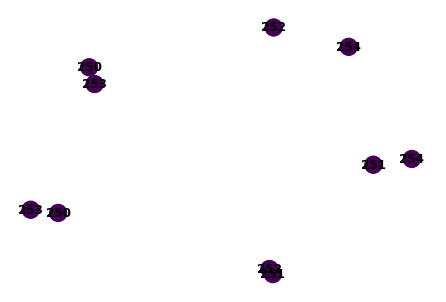

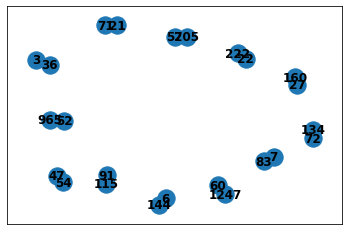

{'recall': 0, 'precision': 0, 'f1_score': 0, 'ged': -1, 'auc': nan}

<Figure size 432x288 with 0 Axes>

In [96]:
import networkx as nx 

get_accuracy(data, edge_masks[1], list_test_nodes[1], args, top=True, num_top_edges=12)

[]
new_edges []


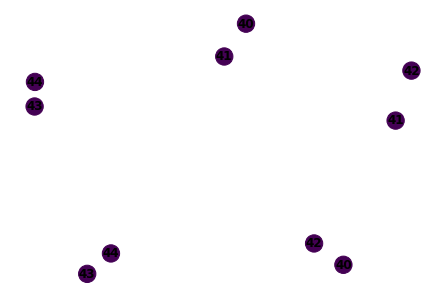

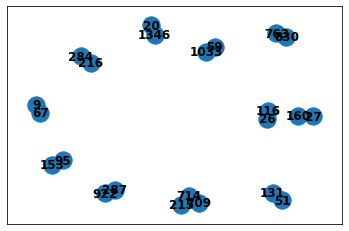

[]
new_edges []


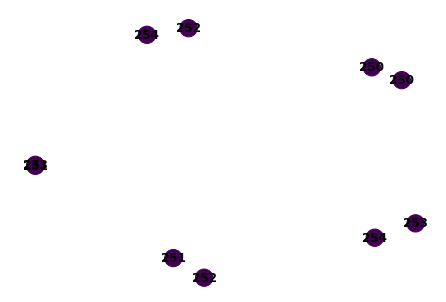

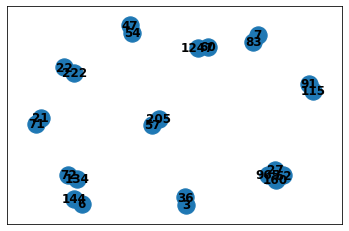

[]
new_edges []


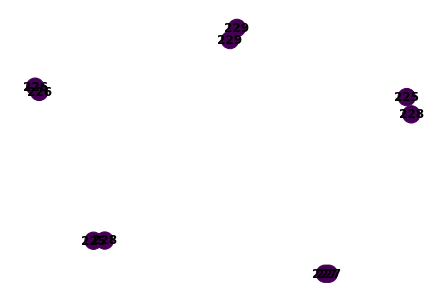

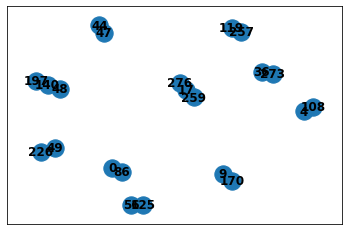

[1507 1508 1531 1547]
new_edges [[75 77]
 [75 79]
 [77 75]
 [79 75]]


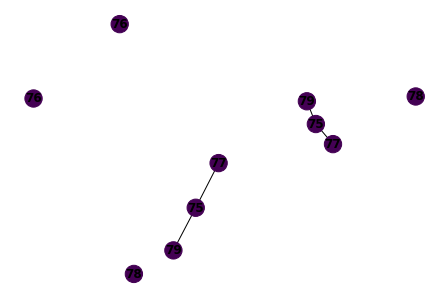

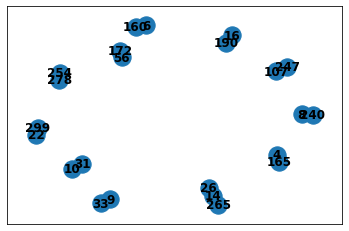

[]
new_edges []


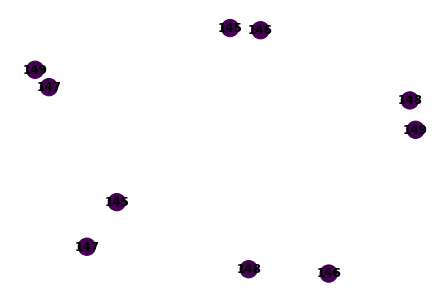

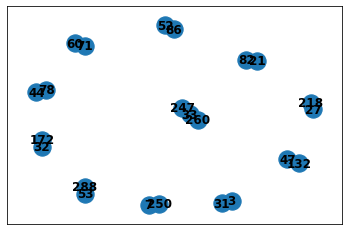

[]
new_edges []


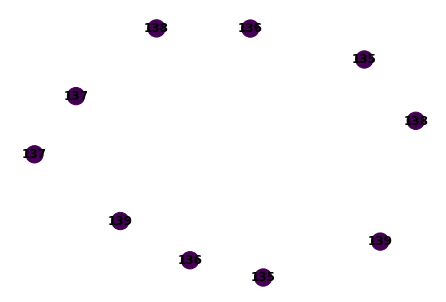

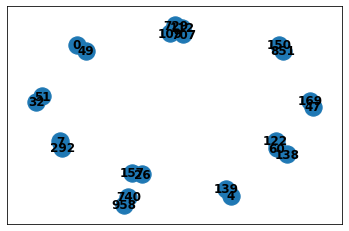

[]
new_edges []


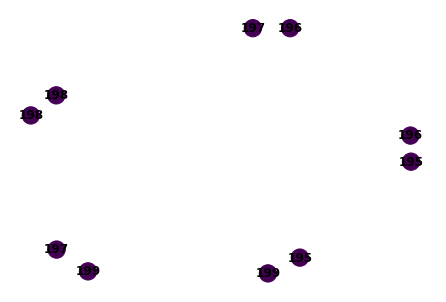

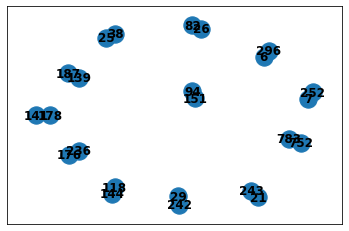

[]
new_edges []


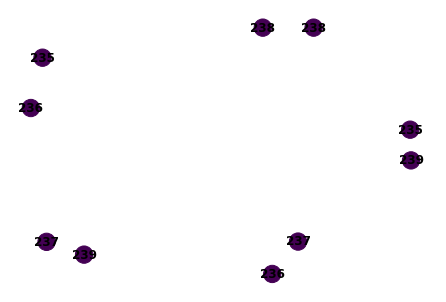

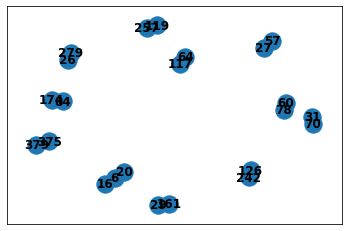

[793 825 851 861]
new_edges [[26 28]
 [27 29]
 [28 26]
 [29 27]]


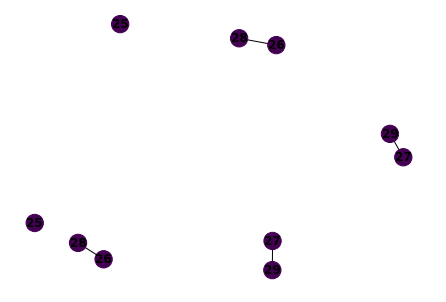

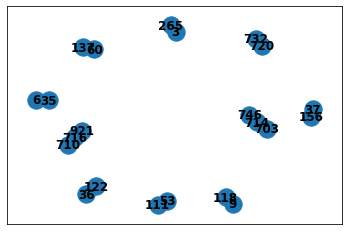

[152 153 154 190 191 192 193 260 261 262 263 329 330 331 366 367]
new_edges [[5 6]
 [5 7]
 [5 8]
 [6 5]
 [6 7]
 [6 8]
 [6 9]
 [7 5]
 [7 6]
 [7 8]
 [7 9]
 [8 5]
 [8 6]
 [8 7]
 [9 6]
 [9 7]]


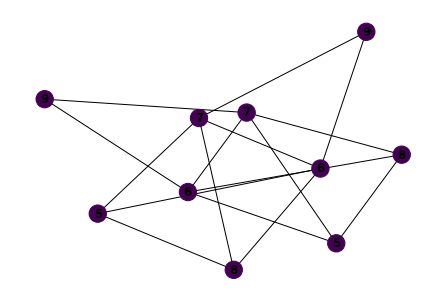

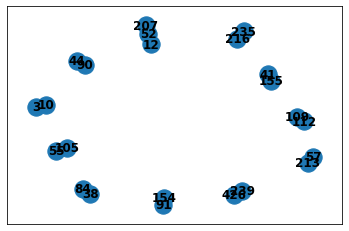

{'recall': 0.0, 'precision': 0.0, 'f1_score': 0.0, 'ged': -1.0, 'auc': nan}

<Figure size 432x288 with 0 Axes>

In [97]:
acc_top = eval_accuracy(data, edge_masks, list_test_nodes, args, top=True, num_top_edges=12)
acc_top

[]
new_edges []


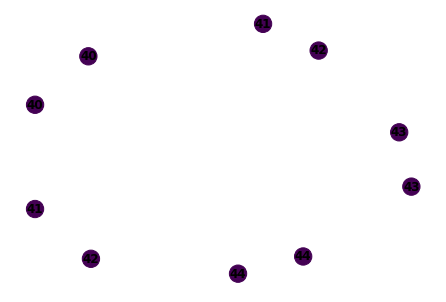

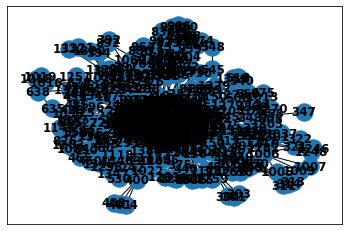

[]
new_edges []


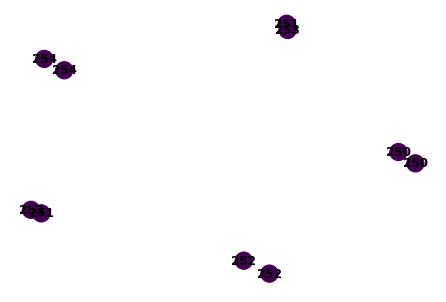

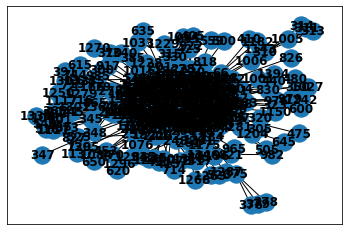

[]
new_edges []


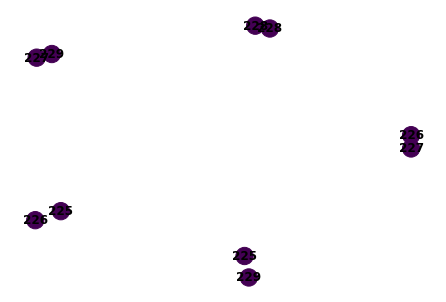

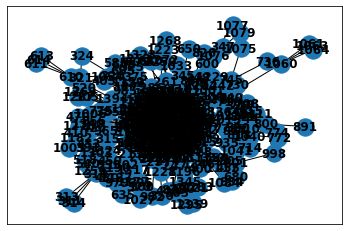

[1507 1508 1531 1547]
new_edges [[75 77]
 [75 79]
 [77 75]
 [79 75]]


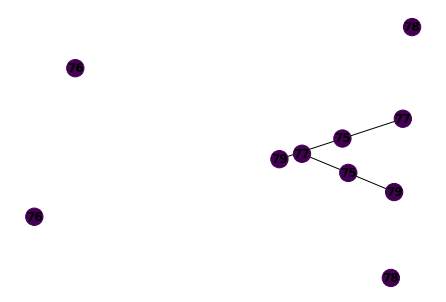

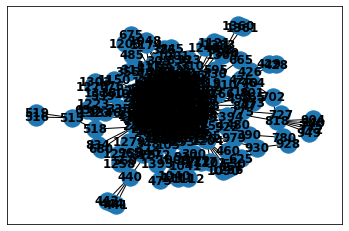

[]
new_edges []


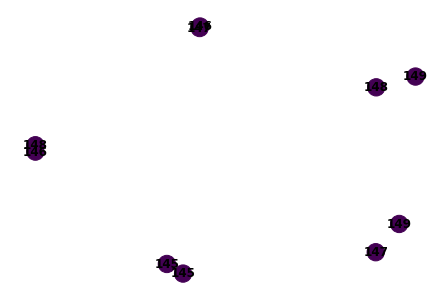

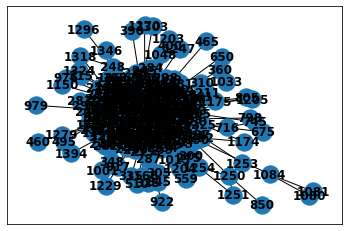

[]
new_edges []


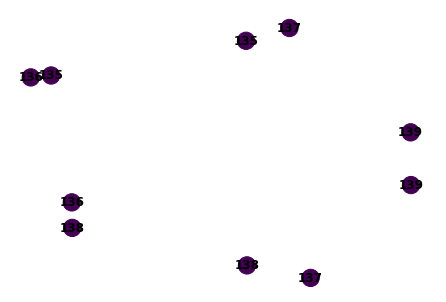

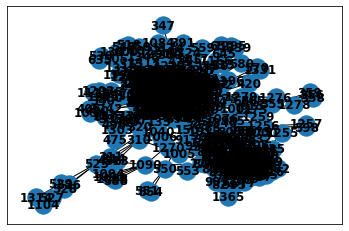

[]
new_edges []


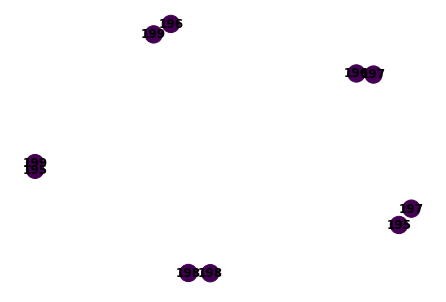

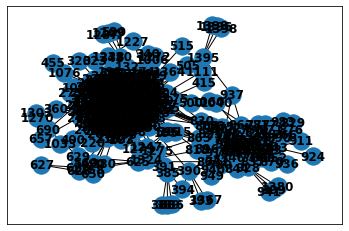

[]
new_edges []


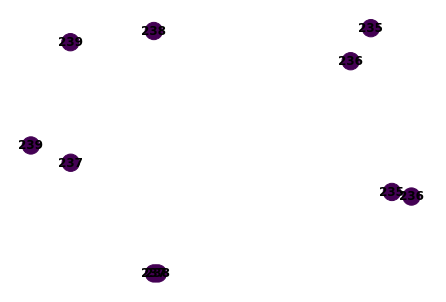

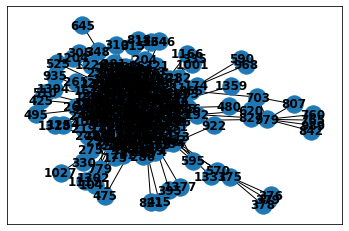

[793 825 851 861]
new_edges [[26 28]
 [27 29]
 [28 26]
 [29 27]]


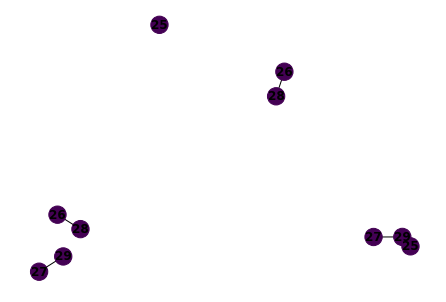

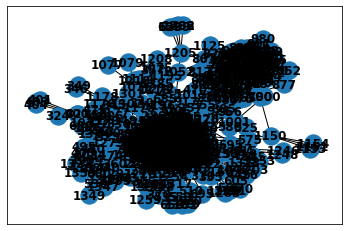

[152 153 154 190 191 192 193 260 261 262 263 329 330 331 366 367]
new_edges [[5 6]
 [5 7]
 [5 8]
 [6 5]
 [6 7]
 [6 8]
 [6 9]
 [7 5]
 [7 6]
 [7 8]
 [7 9]
 [8 5]
 [8 6]
 [8 7]
 [9 6]
 [9 7]]


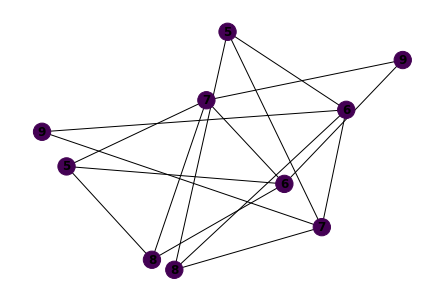

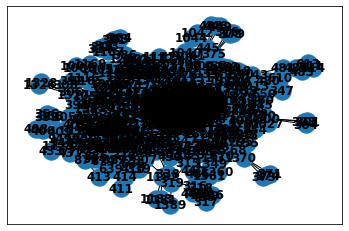

{'recall': 0.3,
 'precision': 0.0006228376790089463,
 'f1_score': 0.0012419119166102717,
 'ged': -1.0,
 'auc': nan}

<Figure size 432x288 with 0 Axes>

In [98]:
acc = eval_accuracy(data, edge_masks, list_test_nodes, args, top=False)
acc

### SubgraphX

In [16]:
def explain_subgraphx(model, node_idx, x, edge_index, target, device, args, include_edges=None):
    subgraphx = SubgraphX(model, label_dim, device, num_hops=2, explain_graph=False)
    edge_mask = subgraphx.explain(x, edge_index, max_nodes=6, label=target, node_idx=node_idx)
    return edge_mask


In [18]:
from torch_geometric.nn import GNNExplainer
import random

edge_masks = []

for node_idx in list_test_nodes:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    print(x_c)
    print(edge_index_c)
    edge_mask = explain_subgraphx(model, node_idx, x_c, edge_index_c, target, device, args)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

175
tensor([[0.3339, 0.3803, 0.5607,  ..., 0.5643, 0.4561, 0.5380],
        [0.4821, 0.3200, 0.5393,  ..., 0.4121, 0.3179, 0.5954],
        [0.1685, 0.5648, 0.2671,  ..., 0.2877, 0.5318, 0.4104],
        ...,
        [0.6635, 0.6217, 0.6538,  ..., 0.5582, 0.3775, 0.5599],
        [0.8222, 0.5856, 0.7790,  ..., 0.5678, 0.4655, 0.5257],
        [0.5954, 0.6432, 0.5927,  ..., 0.5396, 0.5754, 0.5372]])
tensor([[   0,    0,    0,  ..., 1398, 1399, 1399],
        [   1,    2,    3,  ..., 1397, 1395, 1396]])


KeyboardInterrupt: 

### Saliency

In [ ]:
def explain_sa(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward)
    input_mask = torch.ones(edge_index.shape[1]).requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target,
                                       additional_forward_args=(model, node_idx, x, edge_index), abs=False)

    edge_mask = saliency_mask.cpu().numpy()
    return edge_mask

def explain_sa_node(model, node_idx, x, edge_index, target, include_edges=None):
    saliency = Saliency(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    saliency_mask = saliency.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                                       abs=False)

    node_attr = saliency_mask.cpu().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

#explainer = GNNExplainer(model)
for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_sa_node(model, node_idx, x_c, edge_index_c, target, device)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

## Integrated Gradient

In [ ]:
def explain_ig_node(model, node_idx, x, edge_index, target, include_edges=None):
    ig = IntegratedGradients(model_forward_node)
    input_mask = x.clone().requires_grad_(True).to(device)
    ig_mask = ig.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx),
                           internal_batch_size=input_mask.shape[0])

    node_attr = ig_mask.cpu().detach().numpy().sum(axis=1)
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

#explainer = GNNExplainer(model)
for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_ig_node(model, node_idx, x_c, edge_index_c, target, device)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

## Occlusion

In [ ]:
def explain_occlusion(model, node_idx, x, edge_index, target, include_edges=None):
    depth_limit = model.num_layers + 1
    data = Data(x=x, edge_index=edge_index)
    pred_prob = model(data.x, data.edge_index)[node_idx][target].item()
    g = to_networkx(data)
    subgraph_nodes = []
    for k, v in nx.shortest_path_length(g, target=node_idx).items():
        if v < depth_limit:
            subgraph_nodes.append(k)
    subgraph = g.subgraph(subgraph_nodes)
    edge_occlusion_mask = np.ones(data.num_edges, dtype=bool)
    edge_mask = np.zeros(data.num_edges)
    edge_index_numpy = data.edge_index.cpu().numpy()
    for i in range(data.num_edges):
        if include_edges is not None and not include_edges[i].item():
            continue
        u, v = list(edge_index_numpy[:, i])
        if (u, v) in subgraph.edges():
            edge_occlusion_mask[i] = False
            prob = model(data.x, data.edge_index[:, edge_occlusion_mask])[node_idx][target].item()
            edge_mask[i] = pred_prob - prob
            edge_occlusion_mask[i] = True
    return edge_mask


In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_occlusion(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

## PGM-Explainer

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Node_Explainer:
    def __init__(
            self,
            model,
            edge_index,
            X,
            num_layers,
            mode=0,
            print_result=1
    ):
        self.model = model
        self.model.eval()
        self.edge_index = edge_index
        self.X = X
        self.num_layers = num_layers
        self.mode = mode
        self.print_result = print_result

    def perturb_features_on_node(self, feature_matrix, node_idx, random=0, mode=0):
        # return a random perturbed feature matrix
        # random = 0 for nothing, 1 for random.
        # mode = 0 for random 0-1, 1 for scaling with original feature

        X_perturb = feature_matrix
        if mode == 0:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.random.randint(2, size=X_perturb[node_idx].shape[0])
            X_perturb[node_idx] = perturb_array
        elif mode == 1:
            if random == 0:
                perturb_array = X_perturb[node_idx]
            elif random == 1:
                perturb_array = np.multiply(X_perturb[node_idx],
                                            np.random.uniform(low=0.0, high=2.0, size=X_perturb[node_idx].shape[0]))
            X_perturb[node_idx] = perturb_array
        return X_perturb

    def explain(self, node_idx, target, num_samples=100, top_node=None, p_threshold=0.05, pred_threshold=0.1):
        neighbors, _, _, _ = k_hop_subgraph(node_idx, self.num_layers, self.edge_index)
        neighbors = neighbors.cpu().detach().numpy()

        if (node_idx not in neighbors):
            neighbors = np.append(neighbors, node_idx)

        pred_torch = self.model(self.X, self.edge_index).cpu()
        soft_pred = np.asarray([softmax(np.asarray(pred_torch[node_].data)) for node_ in range(self.X.shape[0])])

        pred_node = np.asarray(pred_torch[node_idx].data)
        label_node = np.argmax(pred_node)
        soft_pred_node = softmax(pred_node)

        Samples = []
        Pred_Samples = []

        for iteration in range(num_samples):

            X_perturb = self.X.cpu().detach().numpy()
            sample = []
            for node in neighbors:
                seed = np.random.randint(2)
                if seed == 1:
                    latent = 1
                    X_perturb = self.perturb_features_on_node(X_perturb, node, random=seed)
                else:
                    latent = 0
                sample.append(latent)

            X_perturb_torch = torch.tensor(X_perturb, dtype=torch.float).to(device)
            pred_perturb_torch = self.model(X_perturb_torch, self.edge_index).cpu()
            soft_pred_perturb = np.asarray(
                [softmax(np.asarray(pred_perturb_torch[node_].data)) for node_ in range(self.X.shape[0])])

            sample_bool = []
            for node in neighbors:
                if (soft_pred_perturb[node, target] + pred_threshold) < soft_pred[node, target]:
                    sample_bool.append(1)
                else:
                    sample_bool.append(0)

            Samples.append(sample)
            Pred_Samples.append(sample_bool)

        Samples = np.asarray(Samples)
        Pred_Samples = np.asarray(Pred_Samples)
        Combine_Samples = Samples - Samples
        for s in range(Samples.shape[0]):
            Combine_Samples[s] = np.asarray(
                [Samples[s, i] * 10 + Pred_Samples[s, i] + 1 for i in range(Samples.shape[1])])

        data_pgm = pd.DataFrame(Combine_Samples)
        data_pgm = data_pgm.rename(columns={0: 'A', 1: 'B'})  # Trick to use chi_square test on first two data columns
        ind_ori_to_sub = dict(zip(neighbors, list(data_pgm.columns)))

        p_values = []
        for node in neighbors:
            if node == node_idx:
                p = 0 # p<0.05 => we are confident that we can reject the null hypothesis (i.e. the prediction is the same after perturbing the neighbouring node 
                # => this neighbour has no influence on the prediction - should not be in the explanation)
            else:
                chi2, p,_ = chi_square(ind_ori_to_sub[node], ind_ori_to_sub[node_idx], [], data_pgm, boolean=False, significance_level=0.05)
            p_values.append(p)

        pgm_stats = dict(zip(neighbors, p_values))
        return pgm_stats

In [ ]:
def explain_pgmexplainer(model, node_idx, x, edge_index, target, include_edges=None):
    explainer = Node_Explainer(model, edge_index, x, model.num_layers, print_result=0)
    explanation = explainer.explain(node_idx,target)
    node_attr = np.zeros(x.shape[0])
    for node, p_value in explanation.items():
        node_attr[node] = 1 - p_value
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_pgmexplainer(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)

## Random

In [ ]:
def explain_random(model, node_idx, x, edge_index, target, include_edges=None):
    return np.random.uniform(size=edge_index.shape[1])

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_random(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10], params)
eval_fidelity(related_preds)

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds_sub = eval_related_pred_subgraph(model, data, edge_masks, list_test_nodes[:10], params)
eval_fidelity(related_preds_sub)

## Distance

In [ ]:
def explain_distance(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    length = nx.shortest_path_length(g, target=node_idx)

    def get_attr(node):
        if node in length:
            return 1 / (length[node] + 1)
        return 0

    edge_sources = edge_index[1].cpu().numpy()
    return np.array([get_attr(node) for node in edge_sources])

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_distance(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10], params)
eval_fidelity(related_preds)

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds_sub = eval_related_pred_subgraph(model, data, edge_masks, list_test_nodes[:10], params)
eval_fidelity(related_preds_sub)

## PageRank

In [80]:
def explain_pagerank(model, node_idx, x, edge_index, target, include_edges=None):
    data = Data(x=x, edge_index=edge_index)
    g = to_networkx(data)
    pagerank = nx.pagerank(g, personalization={node_idx: 1})

    node_attr = np.zeros(x.shape[0])
    for node, value in pagerank.items():
        node_attr[node] = value
    print(edge_index[0])
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [91]:
edge_masks = []

for node_idx in list_test_nodes:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_pagerank(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:args.num_top_edges]
    print(edge_index_c[:,indices])

397
tensor([   0,    0,    0,  ..., 1018, 1019, 1019])
tensor([[397, 394, 397, 396, 397, 398, 394, 395, 393, 394, 394, 391],
        [394, 397, 396, 397, 398, 397, 395, 394, 394, 393, 391, 394]])
910
tensor([   0,    0,    0,  ..., 1018, 1019, 1019])
tensor([[910, 907, 910, 911, 910, 909, 907, 908, 907, 906, 907, 904],
        [907, 910, 911, 910, 909, 910, 908, 907, 906, 907, 904, 907]])
850
tensor([   0,    0,    0,  ..., 1018, 1019, 1019])
tensor([[850, 853, 851, 850, 850, 849, 853, 852, 854, 853, 856, 853],
        [853, 850, 850, 851, 849, 850, 852, 853, 853, 854, 853, 856]])
484
tensor([   0,    0,    0,  ..., 1018, 1019, 1019])
tensor([[485, 484, 487, 484, 484, 484, 483, 481, 485, 488, 487, 488],
        [484, 485, 484, 487, 483, 481, 484, 484, 488, 485, 488, 487]])
657
tensor([   0,    0,    0,  ..., 1018, 1019, 1019])
tensor([[657, 658, 654, 657, 658, 655, 654, 655, 659, 658, 651, 654],
        [658, 657, 657, 654, 655, 658, 655, 654, 658, 659, 654, 651]])
624
tensor([   0,   

In [92]:
edge_masks = normalize_all_masks(edge_masks)

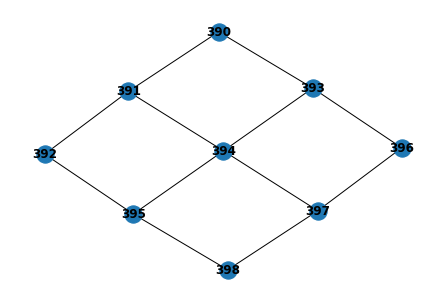

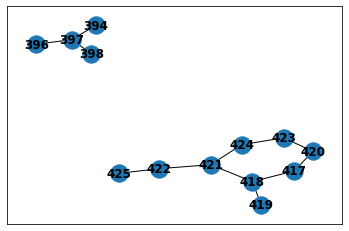

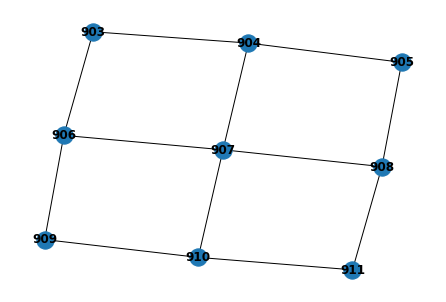

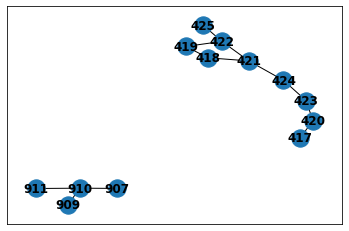

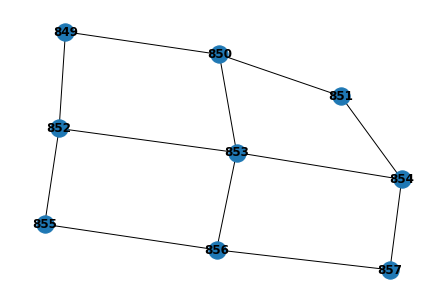

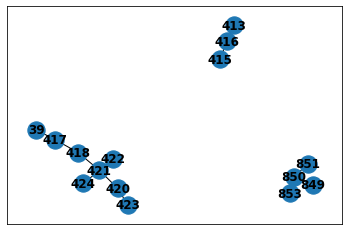

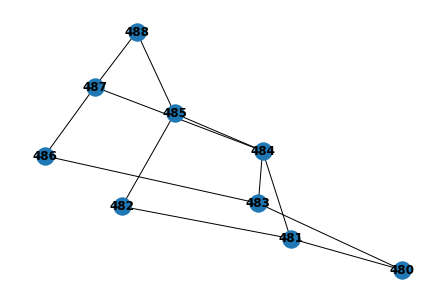

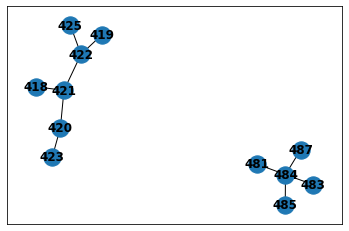

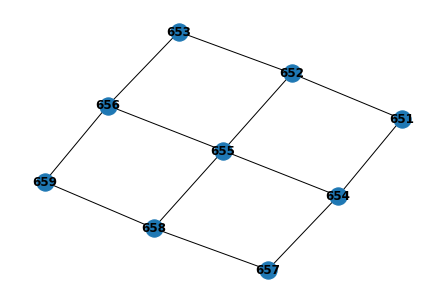

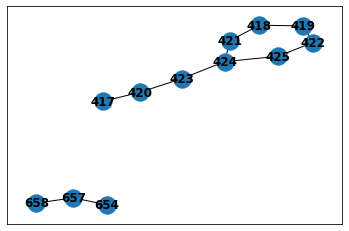

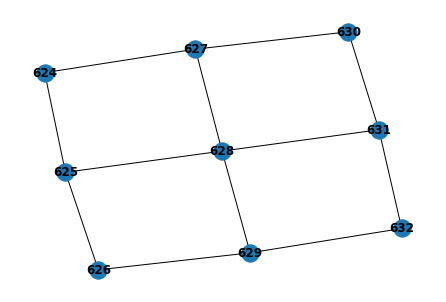

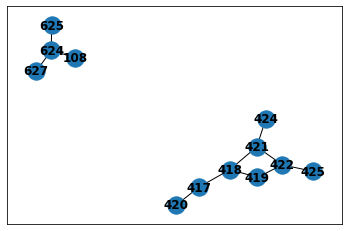

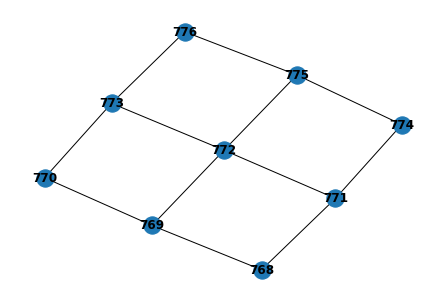

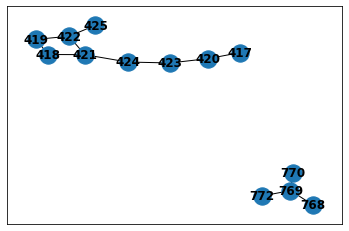

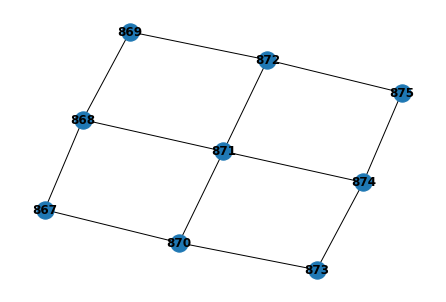

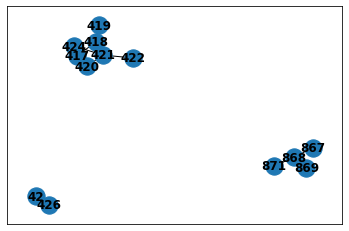

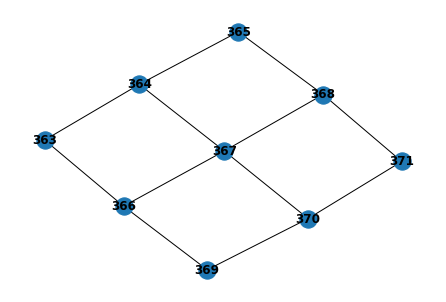

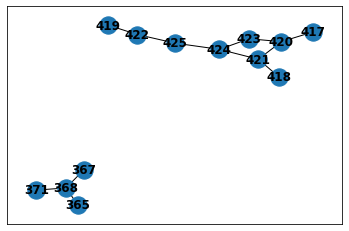

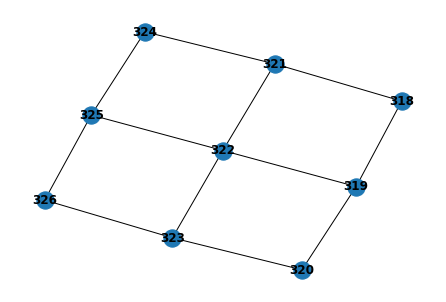

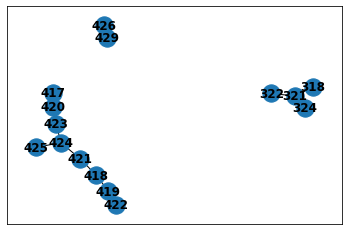

{'recall': 0.24166666666666664,
 'precision': 0.2536363636363636,
 'f1_score': 0.24723320158102763,
 'ged': -1.0,
 'auc': 0.6208168512658228}

<Figure size 432x288 with 0 Axes>

In [99]:
acc_top = eval_accuracy(data, edge_masks, list_test_nodes, args, top=True, num_top_edges=12)
acc_top

In [94]:
def transform_mask(masks, threshold):
    new_masks = []
    for mask in masks:
        mask = np.where(mask>threshold, mask, 0)
        new_masks.append(mask)
    return(new_masks)

In [95]:
len(edge_masks[0][edge_masks[0]>0])

5076

In [96]:
edge_masks = transform_mask(edge_masks, threshold=0.7)

In [97]:
len(edge_masks[0][edge_masks[0]>0])

6

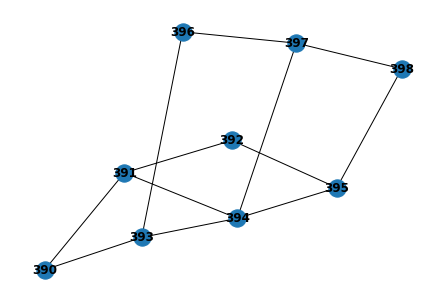

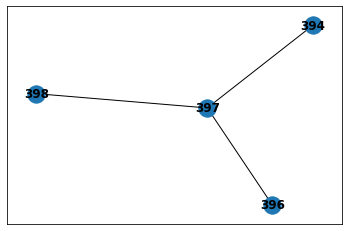

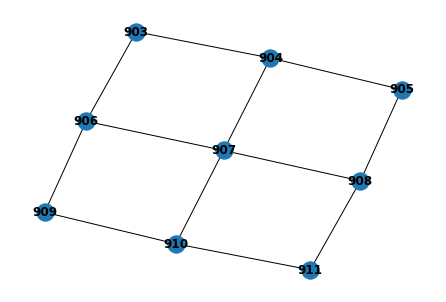

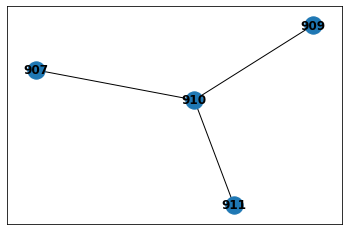

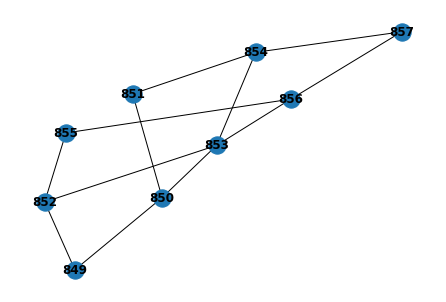

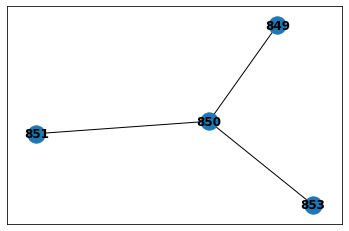

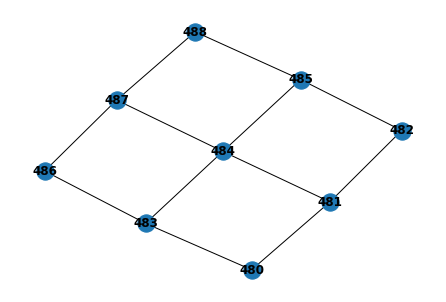

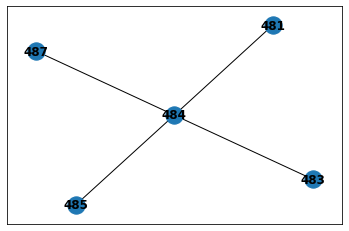

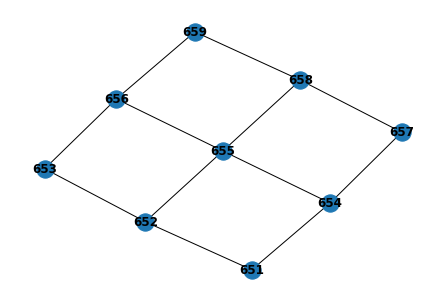

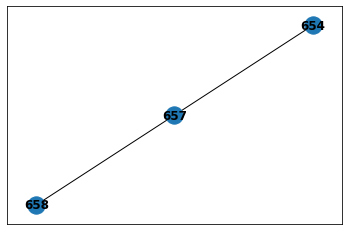

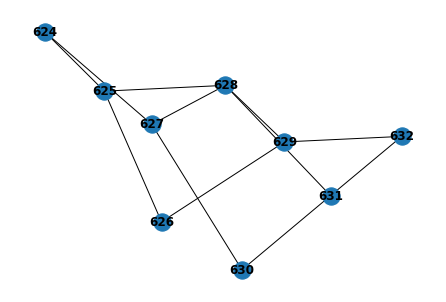

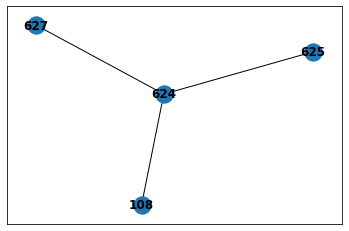

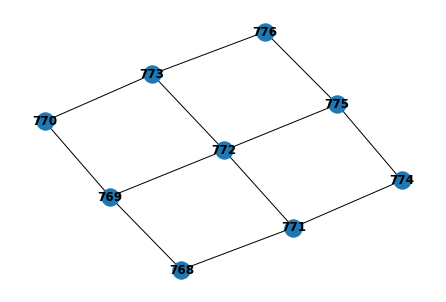

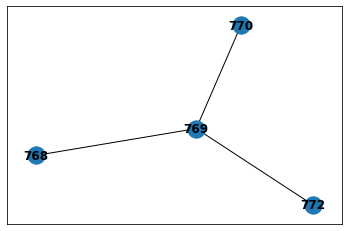

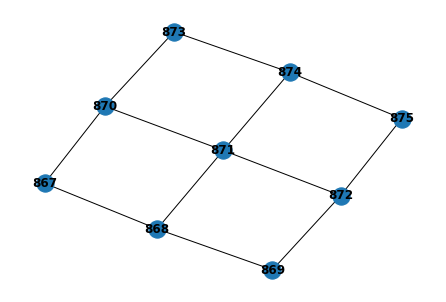

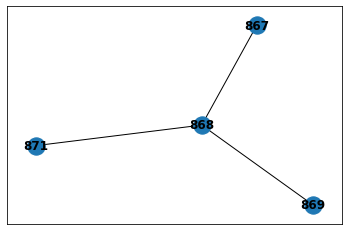

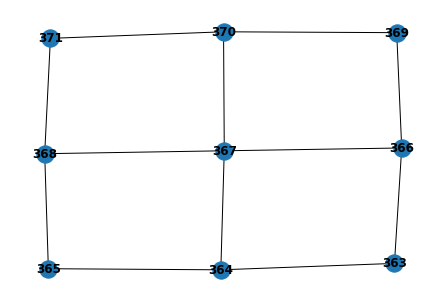

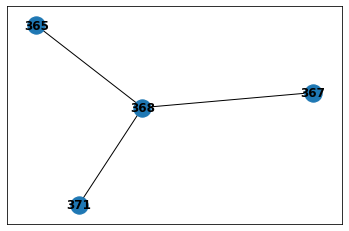

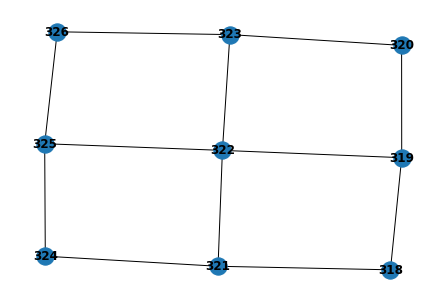

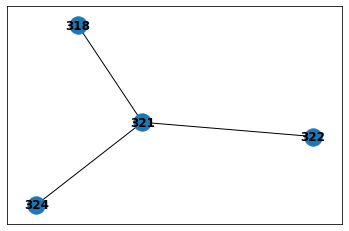

{'recall': 0.24166666666666664,
 'precision': 0.9666666666666666,
 'f1_score': 0.38523809523809527,
 'ged': -1.0,
 'auc': 0.6208168512658228}

<Figure size 432x288 with 0 Axes>

In [98]:
acc = eval_accuracy(data, edge_masks, list_test_nodes, args, top=False)
acc

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:30], params)
eval_fidelity(related_preds)

In [ ]:
params = {'sparsity':0.7, 'normalize':True, 'hard_mask':True}
related_preds_sub = eval_related_pred_subgraph(model, data, edge_masks, list_test_nodes[:30], params)
eval_fidelity(related_preds_sub)

## GradXact

In [ ]:
for module in model.modules():
    print(module)

In [ ]:
def get_all_convolution_layers(model):
    layers = []
    for module in model.modules():
        if isinstance(module, MessagePassing) | isinstance(module, GraphConv):
            layers.append(module)
    return layers

In [ ]:
def explain_gradXact(model, node_idx, x, edge_index, target, include_edges=None):
    # Captum default implementation of LayerGradCam does not average over nodes for different channels because of
    # different assumptions on tensor shapes
    input_mask = x.clone().requires_grad_(True).to(device)
    layers = get_all_convolution_layers(model)
    print(layers)
    node_attrs = []
    for layer in layers:
        layer_gc = LayerGradCam(model_forward_node, layer)
        node_attr,_ = layer_gc.attribute(input_mask, target=target, additional_forward_args=(model, edge_index, node_idx))
        print(node_attr)
        node_attr = node_attr.cpu().detach().numpy().ravel()
        node_attrs.append(node_attr)
    print(node_attrs)
    node_attr = np.array(node_attrs).mean(axis=0)
    print(node_attr)
    print(edge_index[0])
    edge_mask = node_attr_to_edge(edge_index, node_attr)
    return edge_mask

In [ ]:
list_test_nodes = range(n_basis, n_basis+n_shapes*5)
edge_masks = []

for node_idx in list_test_nodes[:10]:
    x_c = torch.FloatTensor(data.x.detach().numpy().copy())
    edge_index_c = torch.LongTensor(data.edge_index.detach().numpy().copy())
    target = int(data.y[node_idx])
    print(node_idx)
    edge_mask = explain_gradXact(model, node_idx, x_c, edge_index_c, target)
    
    edge_masks.append(edge_mask)
    indices = (-edge_mask).argsort()[:6]
    print(edge_index_c[:,indices])

In [ ]:
acc = eval_accuracy(data, edge_masks, list_test_nodes[:10], num_top_edges=6)
acc

In [ ]:
related_preds = eval_related_pred(model, data, edge_masks, list_test_nodes[:10])
eval_fidelity(related_preds)